In [1]:
import os
import numpy as np
import pandas as pd
import joblib
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV



# OPTIMIZACIÓN DE LOS MODELOS MÁS PROMETEDORES

# Stacking

### Elección de la mejor combinanción

In [2]:
cleaned_data= pd.read_csv("Data/train_2.csv")

In [3]:
# Separar las características y la variable objetivo
X = cleaned_data.drop(columns=['SalePrice'])
y = cleaned_data['SalePrice']

# Dividir en conjuntos de entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalización de los datos usando MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Definir combinaciones de modelos base
base_models_1 = [
    ('random_forest', RandomForestRegressor(n_estimators=100)),
    ('gradient_boosting', GradientBoostingRegressor(n_estimators=100)),
    ('xgboost', XGBRegressor(n_estimators=100))
]

base_models_2 = [
    ('random_forest', RandomForestRegressor(n_estimators=100)),
    ('lightgbm', LGBMRegressor(n_estimators=100)),
    ('xgboost', XGBRegressor(n_estimators=100))
]

# Modelo que estás usando actualmente
base_models_current = [
    ('random_forest', RandomForestRegressor(n_estimators=100)),
    ('gradient_boosting', GradientBoostingRegressor(n_estimators=100)),
    ('lightgbm', LGBMRegressor(n_estimators=100))
]

# Definir los metamodelos
meta_model_1 = Ridge(alpha=1.0)  # Metamodelo Ridge
meta_model_2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)  # GBT
meta_model_current = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)  # Meta actual

# Definir los modelos de stacking
stacking_model_1 = StackingRegressor(estimators=base_models_1, final_estimator=meta_model_1)
stacking_model_2 = StackingRegressor(estimators=base_models_1, final_estimator=meta_model_2)
stacking_model_3 = StackingRegressor(estimators=base_models_2, final_estimator=meta_model_1)
stacking_model_4 = StackingRegressor(estimators=base_models_2, final_estimator=meta_model_2)
stacking_model_5 = StackingRegressor(estimators=base_models_current, final_estimator=meta_model_1)
stacking_model_6 = StackingRegressor(estimators=base_models_current, final_estimator=meta_model_2)
stacking_model_7 = StackingRegressor(estimators=base_models_1, final_estimator=meta_model_current)
stacking_model_8 = StackingRegressor(estimators=base_models_2, final_estimator=meta_model_current)

# Modelo de stacking actual
stacking_model_current = StackingRegressor(estimators=base_models_current, final_estimator=meta_model_current)

models = [
    ('(Base 1 + Ridge)', stacking_model_1),
    ('(Base 1 + GBT)', stacking_model_2),
    ('(Base 2 + Ridge)', stacking_model_3),
    ('(Base 2 + GBT)', stacking_model_4),
    ('(Current + Ridge)', stacking_model_5),
    ('(Current + GBT)', stacking_model_6),
    ('(Base 1 + Current Meta)', stacking_model_7),  # Nuevo modelo 7
    ('(Base 2 + Current Meta)', stacking_model_8),  # Nuevo modelo 8
    ('(Base Current + XGBoost)', stacking_model_current)  # El modelo actual, último en la lista
]

# Inicializar una lista para almacenar los resultados
results = []

# Definir función para RMSLE
def rmsle(y_true, y_pred):
    y_true = np.maximum(0, y_true)  # Asegurarse de que los valores sean no negativos
    y_pred = np.maximum(0, y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Evaluar cada modelo
for name, model in models:
    # Entrenar el modelo
    model.fit(X_train_scaled, y_train)
    
    # Predicciones en el conjunto de entrenamiento y validación
    train_predictions = model.predict(X_train_scaled)
    test_predictions = model.predict(X_valid_scaled)
    
    # Calcular métricas
    rmsle_train = rmsle(y_train, train_predictions)
    r2_train = r2_score(y_train, train_predictions)
    
    rmsle_test = rmsle(y_valid, test_predictions)
    r2_test = r2_score(y_valid, test_predictions)
    
    # Almacenar los resultados
    results.append({
        'Model': name,
        'RMSLE_Train': round(rmsle_train, 2),
        'R2_Train': round(r2_train, 2),
        'RMSLE_Test': round(rmsle_test, 2),
        'R2_Test': round(r2_test, 2)
    })

# Crear un DataFrame de resultados
results_df = pd.DataFrame(results)

# Mostrar la tabla de resultados
print(results_df)

C:\Users\oscar\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\oscar\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2478
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 70
[LightGBM] [Info] Start training from score 180976.861063
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 69
[LightGBM] [Info] Start training from score 181194.222103
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2247
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 67
[LightGBM] [Info] Star

Lo primero es probar distintas combinaciones para el stacking. 
Cuando se usa un modelo de regresión lineal Ridge, las métricas en validación mejoran, pero el sobreajuste es demasiado alto. La combinación de base_model_1 y XGBoost como metamodelo y el stacking primigenio muestran métricas parejas en train y validation, lo que indica muy poco sobreajuste. Se seleccionan tres modelos: uno con Ridge como metamodelo para ver si el tuning mejora el sobreajuste, el modelo original y base_models_1 + XGBoost.

### K-fold Validation

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import joblib

# Lista de nombres de los modelos y sus rutas de archivo
models_files = [
    ('Stacking_base1_ridge', 'Data/Stacking_base1_ridge.pkl'),
    ('Stacking_base1_xgboost', 'Data/Stacking_base1_xgboost.pkl'),
    ('Stacking_current_xgboost', 'Data/Stacking_current_xgboost.pkl')
]

# Definir el número de pliegues
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Definir función para RMSLE
def rmsle(y_true, y_pred):
    y_true = np.maximum(0, y_true)  # Asegurarse de que los valores sean no negativos
    y_pred = np.maximum(0, y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Evaluar cada modelo
for model_name, model_file in models_files:
    # Cargar el modelo
    model = joblib.load(model_file)
    
    # Lista para almacenar las métricas de cada pliegue
    folds_results = []

    # Crear un loop para la validación K-Fold
    for train_index, valid_index in kf.split(X):
        # Dividir los datos en entrenamiento y validación para este pliegue
        X_train_k, X_valid_k = X.iloc[train_index], X.iloc[valid_index]
        y_train_k, y_valid_k = y.iloc[train_index], y.iloc[valid_index]
        
        # Escalar los datos usando MinMaxScaler
        scaler = MinMaxScaler()
        X_train_k_scaled = scaler.fit_transform(X_train_k)
        X_valid_k_scaled = scaler.transform(X_valid_k)
        
        # Entrenar el modelo
        model.fit(X_train_k_scaled, y_train_k)
        
        # Predicciones
        train_predictions_k = model.predict(X_train_k_scaled)
        valid_predictions_k = model.predict(X_valid_k_scaled)
        
        # Calcular métricas para el conjunto de entrenamiento y validación
        rmsle_train = rmsle(y_train_k, train_predictions_k)
        r2_train = r2_score(y_train_k, train_predictions_k)
        
        rmsle_valid = rmsle(y_valid_k, valid_predictions_k)
        r2_valid = r2_score(y_valid_k, valid_predictions_k)
        
        # Almacenar resultados
        folds_results.append({
            'RMSLE_Train': rmsle_train,
            'R2_Train': r2_train,
            'RMSLE_Valid': rmsle_valid,
            'R2_Valid': r2_valid
        })

    # Crear un DataFrame para mostrar los resultados de este modelo
    results_df = pd.DataFrame(folds_results)
    print(f"Resultados para el modelo {model_name}:\n", results_df)
    
    # Calcular y mostrar las métricas medias
    mean_results = results_df.mean().to_frame().T
    mean_results.index = [f'Mean - {model_name}']
    print(mean_results)


Resultados para el modelo Stacking_base1_ridge:
    RMSLE_Train  R2_Train  RMSLE_Valid  R2_Valid
0     0.065200  0.981073     0.127226  0.909857
1     0.079306  0.973779     0.142891  0.816591
2     0.053891  0.988980     0.134903  0.902954
3     0.069311  0.980828     0.115358  0.899754
                             RMSLE_Train  R2_Train  RMSLE_Valid  R2_Valid
Mean - Stacking_base1_ridge     0.066927  0.981165     0.130094  0.882289
Resultados para el modelo Stacking_base1_xgboost:
    RMSLE_Train  R2_Train  RMSLE_Valid  R2_Valid
0     0.073078  0.968014     0.131537  0.903706
1     0.073897  0.969603     0.143707  0.856049
2     0.070104  0.965895     0.138469  0.902603
3     0.079404  0.965858     0.118702  0.885869
                               RMSLE_Train  R2_Train  RMSLE_Valid  R2_Valid
Mean - Stacking_base1_xgboost     0.074121  0.967343     0.133104  0.887057
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `for

Como era de esperar al tratarse de un conjunto de datos tan pequeño, los resultados de k-validation son algo irregulares.

### Optimización de Hiperparámetros con Validación Cruzada

In [5]:
# Separar características y variable objetivo
X = cleaned_data.drop(columns=['SalePrice'])
y = cleaned_data['SalePrice']

# Dividir en conjuntos de entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalización de los datos usando MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Definir combinaciones de modelos base
base_models_1 = [
    ('random_forest', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gradient_boosting', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('xgboost', XGBRegressor(n_estimators=100, random_state=42))
]

base_models_current = [
    ('random_forest', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gradient_boosting', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('lightgbm', LGBMRegressor(n_estimators=100, random_state=42))
]

# Definir los metamodelos
meta_model_1 = Ridge()
meta_model_current = XGBRegressor(n_estimators=100, random_state=42)  # Meta-modelo para base_models_current

# Lista de modelos y sus combinaciones
models_to_evaluate = [
    (base_models_1, meta_model_1, 'Stacking_base1_ridge'),
    (base_models_1, meta_model_current, 'Stacking_base1_xgboost'),
    (base_models_current, meta_model_current, 'Stacking_current_xgboost')
]

# Definir los parámetros de búsqueda aleatoria para cada metamodelo
param_dists = {
    'Stacking_base1_ridge': {
        'final_estimator__alpha': np.linspace(0, 10, 21)  # Ampliar el rango de alpha
    },
    'Stacking_base1_xgboost': {
        'final_estimator__n_estimators': [50, 100, 200, 300, 400],
        'final_estimator__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'final_estimator__max_depth': [3, 4, 5, 6, 7, 8],
        'final_estimator__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'final_estimator__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'final_estimator__lambda': [0, 0.5, 1, 1.5, 2, 3],
        'final_estimator__gamma': [0, 0.1, 0.5, 1]  # Añadir gamma
    },
    'Stacking_current_xgboost': {
        'final_estimator__n_estimators': [50, 100, 200, 300, 400],
        'final_estimator__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'final_estimator__max_depth': [3, 4, 5, 6, 7, 8],
        'final_estimator__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'final_estimator__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'final_estimator__lambda': [0, 0.5, 1, 1.5, 2, 3],
        'final_estimator__gamma': [0, 0.1, 0.5, 1]  # Añadir gamma
    }
}

# Definir la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Definir función para RMSLE
def rmsle(y_true, y_pred):
    y_true = np.maximum(0, y_true)  # Asegurarse de que los valores sean no negativos
    y_pred = np.maximum(0, y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Evaluar cada modelo
for base_models, meta_model, model_name in models_to_evaluate:
    # Definir el modelo de stacking
    stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=stacking_model,
        param_distributions=param_dists[model_name],
        n_iter=50,  # Aumentar el número de combinaciones a probar
        scoring='neg_mean_squared_error',  # Focaliza en error de generalización
        cv=kf,
        random_state=42,
        n_jobs=-1
    )

    # Ejecutar la búsqueda
    random_search.fit(X_train_scaled, y_train)

    # Obtener el mejor modelo
    best_model = random_search.best_estimator_
    print(f"Mejores parámetros para {model_name}:", random_search.best_params_)

    # Evaluar el modelo en el conjunto de entrenamiento y validación
    train_predictions = best_model.predict(X_train_scaled)
    test_predictions = best_model.predict(X_valid_scaled)

    # Calcular métricas
    rmsle_train = rmsle(y_train, train_predictions)
    r2_train = r2_score(y_train, train_predictions)
    rmsle_test = rmsle(y_valid, test_predictions)
    r2_test = r2_score(y_valid, test_predictions)

    # Mostrar resultados
    print(f"Resultados para el modelo {model_name}:")
    print(f"RMSLE Train: {rmsle_train:.4f}, R² Train: {r2_train:.4f}")
    print(f"RMSLE Test: {rmsle_test:.4f}, R² Test: {r2_test:.4f}")
    print('-' * 40)

C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores parámetros para Stacking_base1_ridge: {'final_estimator__alpha': 10.0}
Resultados para el modelo Stacking_base1_ridge:
RMSLE Train: 0.0748, R² Train: 0.9756
RMSLE Test: 0.1341, R² Test: 0.9007
----------------------------------------
Mejores parámetros para Stacking_base1_xgboost: {'final_estimator__subsample': 0.7, 'final_estimator__n_estimators': 300, 'final_estimator__max_depth': 3, 'final_estimator__learning_rate': 0.01, 'final_estimator__lambda': 0, 'final_estimator__gamma': 1, 'final_estimator__colsample_bytree': 0.8}
Resultados para el modelo Stacking_base1_xgboost:
RMSLE Train: 0.0844, R² Train: 0.9363
RMSLE Test: 0.1441, R² Test: 0.8850
----------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2478
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 70
[LightGBM

Dado que los resultados de K-validation sugieren poca consistencia en los resultados el tuning se hace sobre una k-validation, para asegurarnos de que estamos capturando el mejor modelo posible. El modelo con Ridge sigue teniendo demasiado sobreajuste, las métricas de los otros dos modelos mejoran de forma interesante alcanzando un buen equilibrio entre train y test.

# Gradient Boost

### Hiperpramatrización con K-validation

In [6]:
cleaned_data= pd.read_csv("Data/train_2.csv")

In [7]:
# Separar las características y la variable objetivo
X = cleaned_data.drop(columns=['SalePrice'])
y = cleaned_data['SalePrice']

# Dividir en entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo base de Gradient Boosting
gbr = GradientBoostingRegressor(random_state=42)

# Configurar el grid de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 300, 500, 1000, 2500],
    'max_depth': [3, 4, 5, 7],
    'learning_rate': [0.01, 0.03, 0.1, 0.2],
    'subsample': [0.5, 0.7, 0.8, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Definir el GridSearchCV
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,  # Validación cruzada de 5 pliegues
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1  # Utilizar todos los núcleos disponibles
)

# Ejecutar el GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y sus parámetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("\nMejores hiperparámetros encontrados:")
print(best_params)

# Evaluar el mejor modelo en el conjunto de entrenamiento y de validación
train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_valid)

# Función para calcular RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

# Calcular métricas
rmsle_train = rmsle(y_train, train_pred)
r2_train = r2_score(y_train, train_pred)

rmsle_test = rmsle(y_valid, test_pred)
r2_test = r2_score(y_valid, test_pred)

print(f"\nMejor Modelo - RMSLE Train: {rmsle_train:.2f}, R2 Train: {r2_train:.2f}")
print(f"Mejor Modelo - RMSLE Test: {rmsle_test:.2f}, R2 Test: {r2_test:.2f}")


# Guardar el mejor modelo
model_filename = 'best_gradient_boosting_model.pkl'
joblib.dump(best_model, model_filename)

print(f"\nModelo guardado como {model_filename}")

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1920 fits failed out of a total of 5760.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1010 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\oscar\anaconda3\Lib\site-pac


Mejores hiperparámetros encontrados:
{'learning_rate': 0.01, 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 2500, 'subsample': 1.0}

Mejor Modelo - RMSLE Train: 0.05, R2 Train: 0.99
Mejor Modelo - RMSLE Test: 0.13, R2 Test: 0.92

Modelo guardado como best_gradient_boosting_model.pkl


De forma análoga se hiperparametriza en una k-validation para asegurarnos de que captamos la mayor cantidad de modelos posibles. el sobreajuste sigue siendo presumiblemente muy alta, es normal que no mejore porque el tuning se hace sobre los resultados del conjunto prueba. Los resultados del conjunto de pruba son muy buenos, eso sí.

Resultados con todas las características:
RMSLE Train: 0.05, R2 Train: 0.99
RMSLE Test: 0.13, R2 Test: 0.92

10 características más importantes:
             Feature  Importance
3        OverallQual    0.110089
16         GrLivArea    0.100533
7          ExterQual    0.080333
14          1stFlrSF    0.072937
62  BsmtQualityScore    0.068887
9           BsmtQual    0.062293
24        GarageArea    0.058978
2       Neighborhood    0.057035
19       KitchenQual    0.047509
15          2ndFlrSF    0.038195

Resultados con Todas:
RMSLE Train: 0.05, R2 Train: 0.99
RMSLE Test: 0.13, R2 Test: 0.92

Resultados con 70 Características:
RMSLE Train: 0.05, R2 Train: 0.99
RMSLE Test: 0.13, R2 Test: 0.92

Resultados con 50 Características:
RMSLE Train: 0.05, R2 Train: 0.99
RMSLE Test: 0.13, R2 Test: 0.92

Resultados con 30 Características:
RMSLE Train: 0.05, R2 Train: 0.99
RMSLE Test: 0.13, R2 Test: 0.92


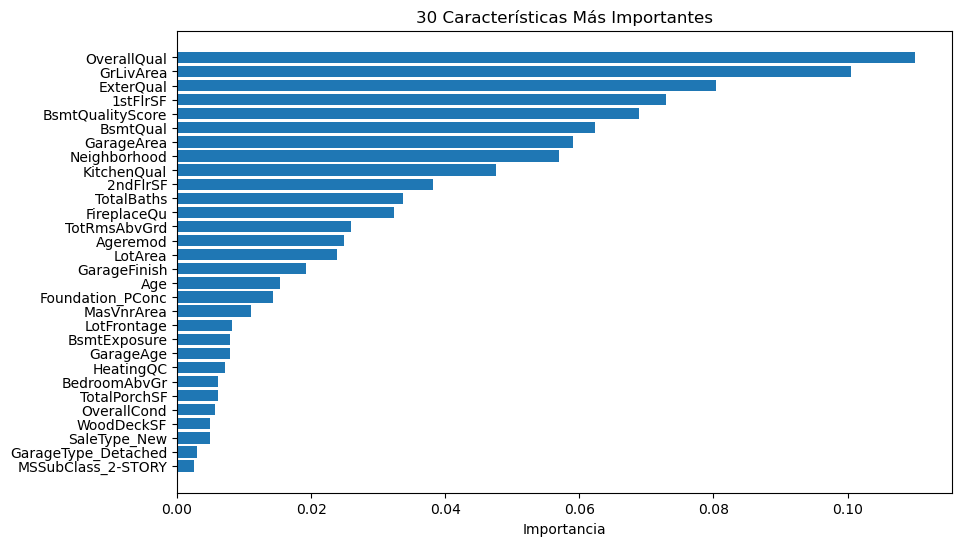

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Entrenar y evaluar Gradient Boosting en el conjunto de datos completo
X = cleaned_data.drop(columns=['SalePrice'])
y = cleaned_data['SalePrice']

# Dividir en entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo Gradient Boosting con los mejores hiperparámetros
gb_model_full = GradientBoostingRegressor(
    n_estimators=2500,
    learning_rate=0.01,
    max_depth=4,
    subsample=1.0,
    max_features='sqrt',
    random_state=42
)
gb_model_full.fit(X_train, y_train)

# Predicciones y métricas
train_pred_full = gb_model_full.predict(X_train)
test_pred_full = gb_model_full.predict(X_valid)

# Función para calcular RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

# Calcular métricas
rmsle_train_full = rmsle(y_train, train_pred_full)
r2_train_full = r2_score(y_train, train_pred_full)
rmsle_test_full = rmsle(y_valid, test_pred_full)
r2_test_full = r2_score(y_valid, test_pred_full)

print("Resultados con todas las características:")
print(f"RMSLE Train: {rmsle_train_full:.2f}, R2 Train: {r2_train_full:.2f}")
print(f"RMSLE Test: {rmsle_test_full:.2f}, R2 Test: {r2_test_full:.2f}")

# 2. Importancia de las características
importances = gb_model_full.feature_importances_
features_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Mostrar las 10 características más importantes (opcional)
print("\n10 características más importantes:")
print(features_importance_df.head(10))

# 3. Crear nuevos conjuntos de datos con las características más importantes
top_70_features = features_importance_df.head(70)['Feature']
top_50_features = features_importance_df.head(50)['Feature']
top_30_features = features_importance_df.head(30)['Feature']

# Crear una lista de conjuntos de características
feature_sets = {
    "Todas": X,
    "70 Características": X[top_70_features],
    "50 Características": X[top_50_features],
    "30 Características": X[top_30_features]
}

# Inicializar diccionario para almacenar resultados
results = {}

# 4. Entrenar y evaluar el modelo Gradient Boosting en los diferentes conjuntos
for name, features in feature_sets.items():
    X_train_set, X_valid_set, y_train_set, y_valid_set = train_test_split(features, y, test_size=0.2, random_state=42)
    
    # Definir el modelo Gradient Boosting con los mejores hiperparámetros
    gb_model = GradientBoostingRegressor(
        n_estimators=2500,
        learning_rate=0.01,
        max_depth=4,
        subsample=1.0,
        max_features='sqrt',
        random_state=42
    )
    
    # Ajustar el modelo
    gb_model.fit(X_train_set, y_train_set)

    # Predicciones y métricas
    train_pred = gb_model.predict(X_train_set)
    test_pred = gb_model.predict(X_valid_set)

    rmsle_train = rmsle(y_train_set, train_pred)
    r2_train = r2_score(y_train_set, train_pred)
    rmsle_test = rmsle(y_valid_set, test_pred)
    r2_test = r2_score(y_valid_set, test_pred)

    # Almacenar los resultados
    results[name] = {
        "RMSLE Train": rmsle_train,
        "R2 Train": r2_train,
        "RMSLE Test": rmsle_test,
        "R2 Test": r2_test
    }

# Imprimir resultados
for key, value in results.items():
    print(f"\nResultados con {key}:")
    print(f"RMSLE Train: {value['RMSLE Train']:.2f}, R2 Train: {value['R2 Train']:.2f}")
    print(f"RMSLE Test: {value['RMSLE Test']:.2f}, R2 Test: {value['R2 Test']:.2f}")

# 5. Graficar importancias de las características (30 más importantes)
plt.figure(figsize=(10, 6))
plt.barh(features_importance_df['Feature'].head(30), features_importance_df['Importance'].head(30))
plt.xlabel('Importancia')
plt.title('30 Características Más Importantes')
plt.gca().invert_yaxis()
plt.show()


# XGBoost

### Hiperparametrización con validación cruzada.

In [9]:
cleaned_data= pd.read_csv("Data/train_2.csv")

In [10]:

# Separar las características y la variable objetivo
X = cleaned_data.drop(columns=['SalePrice'])
y = cleaned_data['SalePrice']

# Dividir en entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo base de XGBoost
xgb = XGBRegressor(random_state=42)

# Configurar el grid de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 300, 1500, 2500, 3000],
    'max_depth': [3, 4, 5, 7],
    'learning_rate': [0.01, 0.015, 0.03, 0.1, 0.2],
    'subsample': [0.3, 0.5, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.6, 0.8, 1.0]
}

# Definir el GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,  # Validación cruzada de 5 pliegues
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1  # Utilizar todos los núcleos disponibles
)

# Ejecutar el GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y sus parámetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("\nMejores hiperparámetros encontrados:")
print(best_params)

# Evaluar el mejor modelo en el conjunto de entrenamiento y de validación
train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_valid)

# Función para calcular RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

# Calcular métricas
rmsle_train = rmsle(y_train, train_pred)
r2_train = r2_score(y_train, train_pred)

rmsle_test = rmsle(y_valid, test_pred)
r2_test = r2_score(y_valid, test_pred)

print(f"\nMejor Modelo - RMSLE Train: {rmsle_train:.2f}, R2 Train: {r2_train:.2f}")
print(f"Mejor Modelo - RMSLE Test: {rmsle_test:.2f}, R2 Test: {r2_test:.2f}")

# Guardar el mejor modelo
model_filename = 'best_xgboost_model.pkl'
joblib.dump(best_model, model_filename)

print(f"\nModelo guardado como {model_filename}")

Fitting 5 folds for each of 3000 candidates, totalling 15000 fits

Mejores hiperparámetros encontrados:
{'colsample_bytree': 0.3, 'learning_rate': 0.015, 'max_depth': 3, 'n_estimators': 2500, 'subsample': 1.0}

Mejor Modelo - RMSLE Train: 0.06, R2 Train: 0.99
Mejor Modelo - RMSLE Test: 0.13, R2 Test: 0.91

Modelo guardado como best_xgboost_model.pkl


Se prueba a tunear XGBoost, dado que es un modelo que históricamente ha funcionado muy bien en este tipo de retos. Los resultados son similares a los de Gradient Boost.

### Importancia de las características

Resultados con todas las características:
RMSLE Train: 0.09, R2 Train: 0.97
RMSLE Test: 0.14, R2 Test: 0.89

10 características más importantes:
             Feature  Importance
3        OverallQual    0.258946
7          ExterQual    0.131989
2       Neighborhood    0.091910
9           BsmtQual    0.077017
23      GarageFinish    0.071034
19       KitchenQual    0.043990
20      TotRmsAbvGrd    0.040948
14          1stFlrSF    0.033503
16         GrLivArea    0.033339
62  BsmtQualityScore    0.024429

Resultados con Todas:
RMSLE Train: 0.06, R2 Train: 0.99
RMSLE Test: 0.13, R2 Test: 0.91

Resultados con 70 Características:
RMSLE Train: 0.06, R2 Train: 0.99
RMSLE Test: 0.13, R2 Test: 0.91

Resultados con 50 Características:
RMSLE Train: 0.06, R2 Train: 0.99
RMSLE Test: 0.13, R2 Test: 0.91

Resultados con 30 Características:
RMSLE Train: 0.06, R2 Train: 0.98
RMSLE Test: 0.13, R2 Test: 0.91


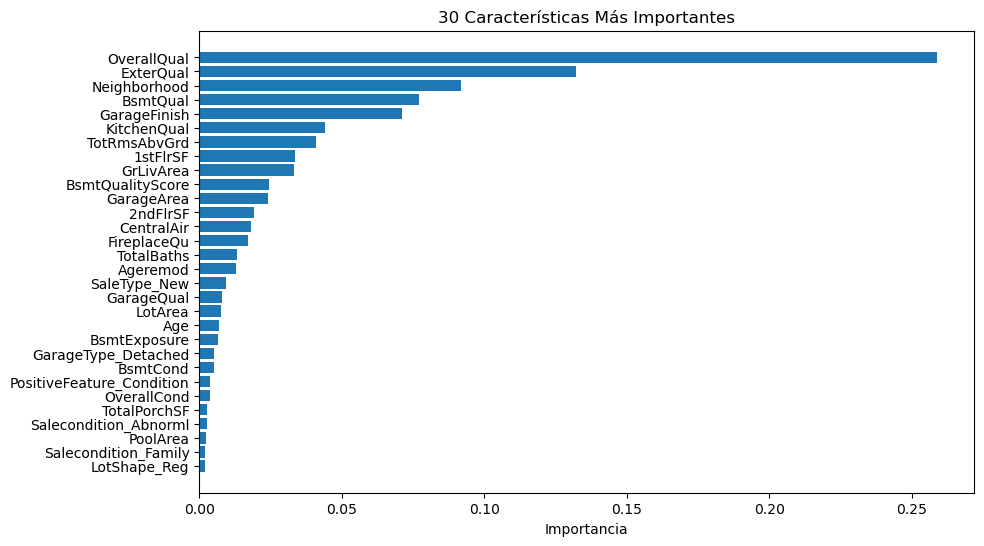

In [11]:
# 1. Entrenar y evaluar XGBoost en el conjunto de datos completo
X = cleaned_data.drop(columns=['SalePrice'])
y = cleaned_data['SalePrice']

# Dividir en entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo XGBoost
xgb_model_full = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model_full.fit(X_train, y_train)

# Predicciones y métricas
train_pred_full = xgb_model_full.predict(X_train)
test_pred_full = xgb_model_full.predict(X_valid)

# Función para calcular RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

# Calcular métricas
rmsle_train_full = rmsle(y_train, train_pred_full)
r2_train_full = r2_score(y_train, train_pred_full)
rmsle_test_full = rmsle(y_valid, test_pred_full)
r2_test_full = r2_score(y_valid, test_pred_full)

print("Resultados con todas las características:")
print(f"RMSLE Train: {rmsle_train_full:.2f}, R2 Train: {r2_train_full:.2f}")
print(f"RMSLE Test: {rmsle_test_full:.2f}, R2 Test: {r2_test_full:.2f}")

# 2. Importancia de las características
importances = xgb_model_full.feature_importances_
features_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Mostrar las 10 características más importantes (opcional)
print("\n10 características más importantes:")
print(features_importance_df.head(10))

# 3. Crear nuevos conjuntos de datos con las características más importantes
top_70_features = features_importance_df.head(70)['Feature']
top_50_features = features_importance_df.head(50)['Feature']
top_30_features = features_importance_df.head(30)['Feature']

# Crear una lista de conjuntos de características
feature_sets = {
    "Todas": X,
    "70 Características": X[top_70_features],
    "50 Características": X[top_50_features],
    "30 Características": X[top_30_features]
}

# Inicializar diccionario para almacenar resultados
results = {}

# 4. Entrenar y evaluar el modelo XGBoost en los diferentes conjuntos
for name, features in feature_sets.items():
    X_train_set, X_valid_set, y_train_set, y_valid_set = train_test_split(features, y, test_size=0.2, random_state=42)
    
    # Definir el modelo XGBoost con los mejores hiperparámetros
    xgb_model = XGBRegressor(
        n_estimators=2500,
        learning_rate=0.015,
        max_depth=3,
        subsample=1.0,
        colsample_bytree=0.3,
        random_state=42
    )
    
    # Ajustar el modelo
    xgb_model.fit(X_train_set, y_train_set)

    # Predicciones y métricas
    train_pred = xgb_model.predict(X_train_set)
    test_pred = xgb_model.predict(X_valid_set)

    rmsle_train = rmsle(y_train_set, train_pred)
    r2_train = r2_score(y_train_set, train_pred)
    rmsle_test = rmsle(y_valid_set, test_pred)
    r2_test = r2_score(y_valid_set, test_pred)

    # Almacenar los resultados
    results[name] = {
        "RMSLE Train": rmsle_train,
        "R2 Train": r2_train,
        "RMSLE Test": rmsle_test,
        "R2 Test": r2_test
    }

# Imprimir resultados
for key, value in results.items():
    print(f"\nResultados con {key}:")
    print(f"RMSLE Train: {value['RMSLE Train']:.2f}, R2 Train: {value['R2 Train']:.2f}")
    print(f"RMSLE Test: {value['RMSLE Test']:.2f}, R2 Test: {value['R2 Test']:.2f}")

# 5. Graficar importancias de las características (30 más importantes)
plt.figure(figsize=(10, 6))
plt.barh(features_importance_df['Feature'].head(30), features_importance_df['Importance'].head(30))
plt.xlabel('Importancia')
plt.title('30 Características Más Importantes')
plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar las más importantes en la parte superior
plt.show()


Exisitia la posibilidad de mejorar el rendimiento del modelo eliminando las características menos importantes, al eliminar ruido. Sin embargo la demostración práctica muestra que es reducción es irrelevante.
La discusión sobre las variables más importantes ya se hará más adelante

In [12]:
#Importancia de las características
importances = xgb_model_full.feature_importances_

# Crear el DataFrame con las importancias
features_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Resetear índice para numerar las filas
features_importance_df = features_importance_df.reset_index(drop=True)

# Crear una nueva columna 'Rank' para numerar las características de mayor a menor importancia
features_importance_df['Rank'] = features_importance_df.index + 1

# Reordenar las columnas para que 'Rank' esté al principio
features_importance_df = features_importance_df[['Rank', 'Feature', 'Importance']]

# Guardar el DataFrame de importancias en un archivo CSV
features_importance_df.to_csv('Data/feature_importances.csv', index=False)

# Mostrar las primeras filas del DataFrame para verificar
print(features_importance_df.head(10))


   Rank           Feature  Importance
0     1       OverallQual    0.258946
1     2         ExterQual    0.131989
2     3      Neighborhood    0.091910
3     4          BsmtQual    0.077017
4     5      GarageFinish    0.071034
5     6       KitchenQual    0.043990
6     7      TotRmsAbvGrd    0.040948
7     8          1stFlrSF    0.033503
8     9         GrLivArea    0.033339
9    10  BsmtQualityScore    0.024429


Exisitia la posibilidad de mejorar el rendimiento del modelo eliminando las características menos importantes, al eliminar ruido. Sin embargo la demostración práctica muestra que los datos incluso empeoran al eliminar variables.
La discusión sobre las variables más importantes ya se hará más adelante.

# Red Neuronal

In [13]:
# Cargar los datos
cleaned_data = pd.read_csv("Data/train_2.csv")

# Separar las características y la variable objetivo
X = cleaned_data.drop(columns=['SalePrice'])
y = cleaned_data['SalePrice']

# Dividir en conjuntos de entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalización de los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Definir la función para calcular RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

# Definir el modelo de la red neuronal
mlp_model = MLPRegressor(max_iter=1000, random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'hidden_layer_sizes': [(32,), (64,), (128,), (64, 64), (128, 64)],  # Añadir más combinaciones
    'activation': ['relu', 'tanh', 'logistic'],  # Funciones de activación adicionales
    'solver': ['adam', 'sgd', 'lbfgs'],  # Añadir el optimizador lbfgs para problemas pequeños
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Añadir un valor mayor para regularización
    'learning_rate_init': [0.001, 0.01, 0.1],  # Añadir valores mayores
    'learning_rate': ['constant', 'invscaling', 'adaptive']  # Añadir tipos de tasa de aprendizaje
}
# Configurar la búsqueda de cuadrícula
grid = GridSearchCV(estimator=mlp_model, param_grid=param_grid, n_jobs=-1, cv=5)  # cv=5 para validación cruzada de 5 pliegues

# Entrenar el modelo
grid_result = grid.fit(X_train_scaled, y_train)

# Obtener los mejores parámetros y el mejor modelo
best_params = grid_result.best_params_
best_model = grid_result.best_estimator_

print(f"Mejores parámetros encontrados: {best_params}")

# Hacer predicciones con el mejor modelo
train_predictions = best_model.predict(X_train_scaled)
valid_predictions = best_model.predict(X_valid_scaled)

# Calcular métricas
rmsle_train = rmsle(y_train, train_predictions)
r2_train = r2_score(y_train, train_predictions)

rmsle_test = rmsle(y_valid, valid_predictions)
r2_test = r2_score(y_valid, valid_predictions)

# Mostrar resultados
print(f'RMSLE Train: {rmsle_train:.2f}, R² Train: {r2_train:.2f}')
print(f'RMSLE Test: {rmsle_test:.2f}, R² Test: {r2_test:.2f}')

C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
168 fits failed out of a total of 8100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
168 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 751, in 

Mejores parámetros encontrados: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'solver': 'adam'}
RMSLE Train: 0.10, R² Train: 0.95
RMSLE Test: 0.15, R² Test: 0.88


Se prueba tambien a optimizar la red nueronal, obteniendo buenos resultados en Train y en test.